In [92]:
import pandas as pd
import  torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import root_mean_squared_error as RMSE
from category_encoders import TargetEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler


In [93]:
url = 'https://raw.githubusercontent.com/goitacademy/MACHINE-LEARNING-NEO/main/datasets/mod_07_topic_13_bigmart_data.csv'
data = pd.read_csv(url)
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [94]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


**Item_Identifier** — унікальний ідентифікатор товару,

**Item_Weight** — вага товару,

**Item_Fat_Content** — категорія жирності продукту,

**Item_Visibility** — відсоток від загальної площі викладки всіх товарів у магазині, виділений для конкретного товару,

**Item_Type** — категорія, до якої належить товар,

**Item_MRP** — максимальна роздрібна ціна (прайс-лист) товару,

**Outlet_Identifier** — унікальний ідентифікатор магазину,

**Outlet_Establishment_Year** — рік заснування магазину,

**Outlet_Size** — розмір (площа) магазину.

**Outlet_Location_Type** — тип населеного пункту, в якому знаходиться магазин,

**Outlet_Type** — тип магазину (звичайний продуктовий магазин чи супермаркет).

**Item_Outlet_Sales** — цільова змінна, продажі товару в конкретному магазині.

In [95]:
data['Outlet_Establishment_Year'] = 2013 - data['Outlet_Establishment_Year']

In [96]:
data['Item_Visibility'] = (data['Item_Visibility'].mask(data['Item_Visibility'].eq(0), np.nan))
data['Item_Visibility_Avg'] = (data.groupby(['Outlet_Type', 'Item_Type'])['Item_Visibility'].transform('mean'))
data['Item_Visibility'] = data['Item_Visibility'].fillna(data['Item_Visibility_Avg'])
data['Item_Visibility_Ratio'] = data['Item_Visibility'] / data['Item_Visibility_Avg']
data[['Item_Visibility', 'Item_Visibility_Ratio']].describe()

,Item_Visibility,Item_Visibility_Ratio
count,8523.000000,8523.000000
mean,0.070440,1.000000
std,0.048885,0.643141
min,0.003575,0.053965
25%,0.033085,0.489270
50%,0.060700,0.891396
75%,0.096335,1.367361
max,0.328391,3.418374


In [97]:
data['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular', 'low fat', 'LF', 'reg'], dtype=object)

In [98]:
data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({'LF': 'Low Fat', 'reg': 'Regular', 'low fat': 'Low Fat'})

In [99]:
data['Item_Identifier'].unique()

array(['FDA15', 'DRC01', 'FDN15', ..., 'NCF55', 'NCW30', 'NCW05'],
      shape=(1559,), dtype=object)

In [100]:
data['Item_Identifier_Type'] = data['Item_Identifier'].str[:2]
data['Item_Identifier_Type'].unique()

array(['FD', 'DR', 'NC'], dtype=object)

In [101]:
data_num = data.select_dtypes(include=np.number)
data_cat = data.select_dtypes(include='object')

X_train_num, X_test_num, X_train_cat, X_test_cat, y_train, y_test = train_test_split(data_num.drop(['Item_Outlet_Sales', 
                                                                                                    'Item_Visibility_Avg'], axis=1), 
                                                                                    data_cat.drop(['Item_Identifier'], 
                                                                                                    axis=1), 
                                                                                                    data['Item_Outlet_Sales'], 
                                                                                                    test_size=0.2, 
                                                                                                    random_state=42)

In [102]:
num_imputer = SimpleImputer(strategy='mean').set_output(transform='pandas')
X_train_num = num_imputer.fit_transform(X_train_num)
X_test_num = num_imputer.transform(X_test_num)

cat_imputer = SimpleImputer(strategy='most_frequent').set_output(transform='pandas')
X_train_cat = cat_imputer.fit_transform(X_train_cat)
X_test_cat = cat_imputer.transform(X_test_cat)


In [103]:
enc_auto = TargetEncoder().set_output(transform='pandas')
X_train_cat = enc_auto.fit_transform(X_train_cat, y_train)
X_test_cat = enc_auto.transform(X_test_cat)

In [104]:
X_train_concat = pd.concat([X_train_num, X_train_cat], axis=1)
X_test_concat = pd.concat([X_test_num, X_test_cat], axis=1)

X_train_concat.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Visibility_Ratio,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Identifier_Type
549,9.500,0.035206,171.3448,14.0,0.522019,2232.878028,2321.843277,2382.120509,2301.333706,1895.446358,2336.111149,2237.307754
7757,18.000,0.047473,170.5422,11.0,0.797281,2185.478564,2261.702912,2228.023712,2301.333706,2333.583503,2336.111149,2159.187339
764,17.600,0.076122,111.7202,16.0,1.338587,2232.878028,2191.256377,2287.769449,1929.302214,1895.446358,2336.111149,2237.307754
6867,8.325,0.029845,41.6138,11.0,0.442534,2185.478564,2321.843277,2228.023712,2301.333706,2333.583503,2336.111149,2237.307754
2716,12.850,0.137228,155.5630,16.0,2.086298,2185.478564,2295.101739,2287.769449,1929.302214,1895.446358,2336.111149,2237.307754


## RandomForestRegressor

In [105]:
clf = (RandomForestRegressor(random_state=42).fit(X_train_concat, y_train))
pred_clf = clf.predict(X_test_concat)
rmse_clf = root_mean_squared_error(y_test, pred_clf)
print(f"Prototype's RMSE on test: {rmse_clf:.1f}")

Prototype's RMSE on test: 1067.6


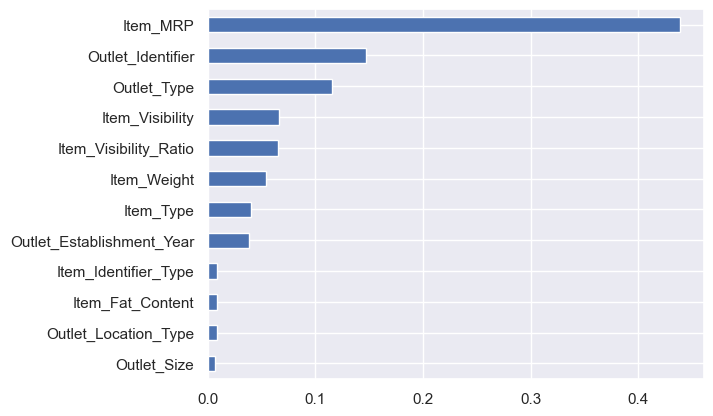

In [106]:
sns.set_theme()

(pd.Series(data=clf.feature_importances_, index=X_train_concat.columns).sort_values(ascending=True).plot.barh())
plt.show()

In [107]:
class VisRatioEstimator(BaseEstimator, TransformerMixin):
  def __init__(self):
      self.vis_avg = None

  def fit(self, X, y=None):
    vis_avg = (
        X.groupby(['Item_Type', 'Outlet_Type'])['Item_Visibility'].mean()
    )
    self.vis_avg = vis_avg
    return self

  def transform(self, X, y=None):
    X = X.copy()
    X['Item_Visibility_Ratio'] = (
        X
        .groupby(['Item_Type', 'Outlet_Type'])['Item_Visibility']
        .transform(lambda x: x / self.vis_avg[x.name])
    )
    return X

In [108]:
vis_est = VisRatioEstimator()
data = (data.rename(columns={'Item_Visibility_Ratio': 'Item_Visibility_Ratio_prev'}))
data = vis_est.fit_transform(data)
(data[['Item_Visibility_Ratio_prev', 'Item_Visibility_Ratio']].sample(10, random_state=42))

,Item_Visibility_Ratio_prev,Item_Visibility_Ratio
7503,0.402694,0.402694
2957,1.319377,1.319377
7031,0.611682,0.611682
1084,0.700654,0.700654
856,0.219033,0.219033
4304,0.663149,0.663149
2132,2.033351,2.033351
1385,0.206023,0.206023
5239,0.341605,0.341605
6516,0.262587,0.262587


In [109]:
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', TargetEncoder())])
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer())])
preprocessor = (ColumnTransformer(
    transformers=[
        ('cat',
         cat_transformer,
         make_column_selector(dtype_include=object)),
        ('num',
         num_transformer,
         make_column_selector(dtype_include=np.number))],
    n_jobs=-1,
    verbose_feature_names_out=False)
    .set_output(transform='pandas'))
model_pipeline = Pipeline(steps=[
    ('vis_estimator', VisRatioEstimator()),
    ('pre_processor', preprocessor),
    ('reg_estimator', RandomForestRegressor(
        n_jobs=-1,
        random_state=42))])

In [110]:
data.drop([
    'Item_Visibility_Avg',
    'Item_Visibility_Ratio_prev',
    'Item_Visibility_Ratio',
    'Item_Identifier_Type'],
    axis=1,
    inplace=True)

In [111]:
X_train, X_test, y_train, y_test = (
train_test_split(
    data.drop(['Item_Identifier',
               'Item_Outlet_Sales'],
               axis=1),
    data['Item_Outlet_Sales'],
    test_size=0.2,
    random_state=42))


In [112]:
model = model_pipeline.fit(X_train, y_train)
pred_pipe = model.predict(X_test)
rmse_pipe = root_mean_squared_error(y_test, pred_pipe)
print(f"Pipe's RMSE on test: {rmse_pipe:.1f}")

Pipe's RMSE on test: 1061.4


## PyTorch

In [113]:
scaler = StandardScaler() #.set.output(transform='pandas')
X_train_scaled = scaler.fit_transform(X_train_concat)   # тут scaler "вчиться"
X_test_scaled  = scaler.transform(X_test_concat)        # тут тільки застосовуємо

In [114]:
y_train.head()

549     2386.2272
7757    3103.9596
764     1125.2020
6867     284.2966
2716    4224.5010
Name: Item_Outlet_Sales, dtype: float64

In [115]:
# Making a PyTorch Dataset

class BigmartDataset(Dataset):
    def __init__(self, X, y, scale=True):        
        # Якщо X — DataFrame, беремо .values
        # Якщо X — вже numpy, просто приводимо до масиву
        if hasattr(X, "values"):        
            self.X = X.values
        else:
            self.X = np.asarray(X)

        self.y = np.asarray(y)

        
        if scale:
            sc = StandardScaler()
            self.X = sc.fit_transform(self.X)

    def __len__(self):
        #return size of a dataset
        return len(self.y)

    def __getitem__(self, idx):
        #supports indexing using dataset[i] to get the i-th row in a dataset
        
        X = torch.tensor(self.X[idx], dtype=torch.float32)
        y = torch.tensor(self.y[idx], dtype=torch.float32)        
        
        return X, y


In [116]:
train_dataset = BigmartDataset(X_train_scaled, y_train, scale=False)
test_dataset  = BigmartDataset(X_test_scaled,  y_test,  scale=False)

In [117]:
# Loading Batches of Data

train_dataloader = DataLoader(train_dataset,
                              batch_size=200,
                              num_workers=0
                             )

test_dataloader = DataLoader(test_dataset,
                              batch_size=200,
                              num_workers=0
                             )


In [118]:
next(iter(train_dataloader))

[tensor([[-0.8014, -0.7247,  0.4707,  ..., -1.6201,  0.1607,  0.5352],
         [ 1.2102, -0.4727,  0.4579,  ...,  0.6927,  0.1607, -0.6613],
         [ 1.1155,  0.1159, -0.4826,  ..., -1.6201,  0.1607,  0.5352],
         ...,
         [-0.1743, -1.0683,  1.7790,  ...,  0.5507, -0.1958,  0.5352],
         [ 0.7842, -0.5343, -1.5759,  ...,  0.6927,  0.1607,  0.5352],
         [-1.2013, -0.3088, -0.3086,  ...,  0.5507, -0.1958,  0.5352]]),
 tensor([2386.2273, 3103.9597, 1125.2020,  284.2966, 4224.5010,  447.4176,
          862.2110, 2269.0464,  639.1680, 9267.9355,  169.1132, 1162.4868,
          305.6022,  713.7376, 2061.3169, 3280.3965, 1402.1748,  487.3656,
         3029.3899, 1846.9292, 5494.8472, 1713.7692, 1332.2657, 2886.2429,
         2446.8149, 3952.1887, 2596.6201,  675.1212,  460.7336, 1911.5118,
          651.1524,   81.2276, 3901.5879, 4306.3945, 1669.8264, 2844.2976,
          705.7480, 3150.5657,  871.5322, 2966.1389, 2077.2959,  394.1536,
         7084.1118, 1451.4440, 12

In [122]:
class LinearModel(torch.nn.Module):
    def __init__(self, in_dim, out_dim=1):
        super().__init__()
                 
        self.features = torch.nn.Sequential(
            nn.Linear(in_dim, 256),
            torch.nn.ReLU(),

            nn.Linear(256, 128),
            torch.nn.ReLU(),

            nn.Linear(128, 64),
            torch.nn.ReLU(),

            nn.Linear(64, out_dim)
        )
    
    def forward(self, x):
        output = self.features(x)
        return output

In [139]:
model = LinearModel(in_dim=X_train_scaled.shape[1], out_dim=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses = []
train_rmses = []
test_losses = []
test_rmses = []

In [140]:
# Train the model

num_epochs = 100

for epoch in range(num_epochs):
    
    # Train step
    
    model.train()
    
    y_pred_train = []
    
    for data in train_dataloader:
        # Get and prepare inputs
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        y_pred_train.extend(outputs.cpu().detach().numpy())
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, RMSE: {RMSE(y_train, y_pred_train)}')
    train_rmses.append(RMSE(y_train, y_pred_train))
    train_losses.append(loss.cpu().detach().numpy())
    
    # Eval step
    
    model.eval()
    
    y_pred_test = []
    
    with torch.no_grad():
        
        for data in test_dataloader:
            # Get and prepare inputs
            inputs, targets = data
            inputs, targets = inputs.float(), targets.float()
            targets = targets.reshape((targets.shape[0], 1))
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # No backward pass
            
            y_pred_test.extend(outputs.cpu().detach().numpy())
        
        test_rmses.append(RMSE(y_test, y_pred_test))
        test_losses.append(loss.cpu().detach().numpy())

Epoch [10/100], Loss: 1035946.7500, RMSE: 1118.2745204522512
Epoch [20/100], Loss: 959024.0000, RMSE: 1105.9487403696216
Epoch [30/100], Loss: 906942.7500, RMSE: 1098.1961178440504
Epoch [40/100], Loss: 856275.6250, RMSE: 1090.2744797322082
Epoch [50/100], Loss: 820413.6875, RMSE: 1083.9640415915428
Epoch [60/100], Loss: 790571.2500, RMSE: 1080.3336532010896
Epoch [70/100], Loss: 763890.1250, RMSE: 1077.899891352964
Epoch [80/100], Loss: 740431.2500, RMSE: 1076.0275934299568
Epoch [90/100], Loss: 722660.7500, RMSE: 1074.3361036068256
Epoch [100/100], Loss: 703556.1875, RMSE: 1072.709631501759


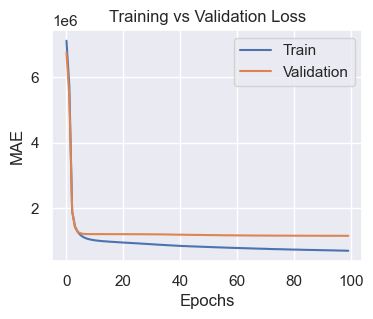

In [141]:
plt.figure(figsize=(4, 3))
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Validation')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Training vs Validation Loss')
plt.show()

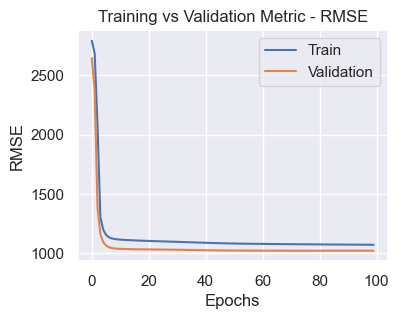

In [142]:
plt.figure(figsize=(4, 3))
plt.plot(train_rmses, label='Train')
plt.plot(test_rmses, label='Validation')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('Training vs Validation Metric - RMSE')
plt.show()